In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
import calendar
from global_land_mask import globe
import glob
import math
from scipy import stats
import os
import netCDF4 as nc

from gcm_loading.highres_read import read_var_hires
from gcm_loading.myReadGCMsDaily import read_var_mod
from gcm_loading.read_amip import read_amip_var
from regrid_wght_3d import regrid_wght_wnans

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.clf()
plt.rcParams['figure.figsize'] = (10, 10)

<Figure size 600x400 with 0 Axes>

In [3]:
from con_models import get_cons
con, use_colors, varname, pvarname, modname, warming_modname, hiresmd, amip = get_cons()

In [4]:
#latitude range
latr1 = 30
latr2 = 80

#pressure levels in observations
p_level_700 = 3  ### 700hPa



In [5]:
l  = 0
mm = len(modname)   #l+1

time1=[2010, 1, 1]
time2=[2012, 12, 30]

#binning
n_bins  = 20
M_range = (-9,-6)

lats_edges = np.arange(latr1,latr2+1,5)
lons_edges = np.arange(-180,181,5)

In [5]:
############## OBS ##################################
import glob
merlist = np.sort(glob.glob('../data_merra/all_lat_lon/level/MERRA2_*.nc'))
sfclist = np.sort(glob.glob('../data_merra/all_lat_lon/surface/MERRA2_*.nc'))
maclist = np.sort(glob.glob('../MACLWP_dailymean/take/wind1deg*.nc4'))

new_list_s = []
new_list_m = []
# new_list_c = []

s = 0
m = 0
length = max(len(merlist), len(sfclist))

In [6]:
while m != length:
    # print(s,m)
    name_s = os.path.basename(sfclist[s])
    date_s = name_s.split(".")[2]

    name_m = os.path.basename(merlist[m])
    date_m = name_m.split(".")[2]
    # print(sfclist[s],date_s)
    # print(merlist[m],date_m)

    if date_s==date_m:
        new_list_s.append(sfclist[s])
        new_list_m.append(merlist[m])

        s = s+1
        m = m+1

    elif date_s<date_m:
        s = s+1

    elif date_s>date_m:
        m = m+1

In [7]:
macwind = []
new_s   = []
new_m   = []
macdate = []
for i in range(len(new_list_s)):
    flag = 0
    name_s = os.path.basename(new_list_s[i])
    date_s = name_s.split(".")[2]

    for k in range(len(maclist)):

        name_mac = os.path.basename(maclist[k])
        date_mac = name_mac.split(".")[1]
        ddata    = nc.Dataset(maclist[k])
        mactime  = ddata.variables['time'][:]
        macw     = ddata.variables['sfcwind'][:]

        if date_mac==date_s[0:-2]:
            for r in range(len(mactime)):
                if str(mactime[r]). zfill(2) == date_s[-2::]:
                    macwind.append(macw[r,:,:])
                    # print(maclist[k],str(mactime[r]). zfill(2))
                    # print(new_list_s[i],date_s)
                    new_m.append(new_list_m[i])
                    new_s.append(new_list_s[i])
                    macdate.append(date_mac+str(mactime[r]). zfill(2))

                    flag = 1
                    break;

        if flag == 1:
            break;


macwind = np.array(macwind)

#####################

In [8]:
p_mer_T   = []
p_mac_w   = []
sfc_mer_T = []
sfc_mer_P = []

for i in range(len(new_s)):
    d_path = new_m[i]
    data   = nc.Dataset(d_path)

    if i==0:
        merlat = data.variables['lat'][:]
        merlon = data.variables['lon'][:]
        merlev = data.variables['lev'][:]
        print(merlev[p_level_700])
        #shape latitude
        mer_lat = np.flip(merlat)
        mer_lat = np.array(mer_lat)
        mlat_ind1 = np.where(mer_lat == mer_lat.flat[np.abs(mer_lat - (latr1)).argmin()])[0]
        mlat_ind2 = np.where(mer_lat == mer_lat.flat[np.abs(mer_lat - (latr2)).argmin()])[0]
        p_mer_lat  = np.array(mer_lat[mlat_ind1[0]:mlat_ind2[0]])
        #shape longitude
        merlon[merlon > 180] = merlon[merlon > 180]-360
        # mer_lon = np.array(merlon)

    merT      = data.variables['T'][:] #(time, lev, lat, lon)
    mer_T     = np.array(merT[:,:,::-1,:])
    mer_T_700 = mer_T[:,p_level_700,mlat_ind1[0]:mlat_ind2[0],:]
    p_mer_T.extend(mer_T_700)

    s_path = new_s[i]
    sdata  = nc.Dataset(s_path)

    sfcT   = sdata.variables['T2M'][:]
    sfc_T = np.array(sfcT[:,::-1,:])
    sfc_mer_T.extend(sfc_T[:,mlat_ind1[0]:mlat_ind2[0],:])


    sfcP   = sdata.variables['SLP'][:]
    sfc_P  = np.array(sfcP[:,::-1,:])
    sfc_mer_P.extend(sfc_P[:,mlat_ind1[0]:mlat_ind2[0],:])


700.0


In [9]:
p_mac_w = macwind[:,mlat_ind1[0]:mlat_ind2[0],:]

wind    = np.array(p_mac_w)
temp    = np.array(p_mer_T)
sfctemp = np.array(sfc_mer_T)
sfcpres = np.array(sfc_mer_P)

grid_obs_wind     = regrid_wght_wnans(p_mer_lat,merlon,wind,lats_edges,lons_edges)[0]
grid_obs_temp_700 = regrid_wght_wnans(p_mer_lat,merlon,temp,lats_edges,lons_edges)[0]
grid_obs_temp_sfc = regrid_wght_wnans(p_mer_lat,merlon,sfctemp,lats_edges,lons_edges)[0]
grid_obs_pres_sfc = regrid_wght_wnans(p_mer_lat,merlon,sfcpres,lats_edges,lons_edges)[0]

lat_n = regrid_wght_wnans(p_mer_lat,merlon,sfcpres,lats_edges,lons_edges)[2][:,0]
lon_n = regrid_wght_wnans(p_mer_lat,merlon,sfcpres,lats_edges,lons_edges)[1][0,:]

theta_700 = np.array(np.multiply(grid_obs_temp_700, (100000/(merlev[p_level_700]*100))**(con)))
theta_sfc = np.array(np.multiply(grid_obs_temp_sfc, (100000/grid_obs_pres_sfc)**(con)))
print('theta_800', np.shape(theta_700))
print('theta_sfc', np.shape(theta_sfc))

p_CAOI = np.array(np.subtract(theta_sfc,theta_700))

theta_800 (1045, 10, 72)
theta_sfc (1045, 10, 72)


In [10]:
#Mask for the ocean
maskm = np.ones((len(temp),len(lat_n),len(lon_n)))

for a in range(len(lat_n)):
    for b in range(len(lon_n)):
        if globe.is_land(lat_n[a], lon_n[b])==True:
            maskm[:,a,b] = math.nan
##############################

In [11]:
#ocean only mask
plot_CAOI = np.array(np.multiply(maskm,p_CAOI))
plot_wind = np.array(np.multiply(maskm,grid_obs_wind))

plot_indx = np.isnan(plot_CAOI*plot_wind)==False
plot_mer_theta = plot_CAOI[plot_indx]
plot_mac_wind  = plot_wind[plot_indx]

w_sfc = plot_mac_wind[plot_mac_wind>0]
m_700 = plot_mer_theta[plot_mac_wind>0]
###################################

from scipy import stats
bin_means_WO, bin_edges_WO, binnumber_WO = stats.binned_statistic(m_700, w_sfc, 'mean', bins=n_bins,range=M_range)
bin_means_MO, bin_edges_MO, binnumber_MO = stats.binned_statistic(m_700, m_700, 'mean', bins=n_bins,range=M_range)
bin_means_CO, bin_edges_CO, binnumber_CO = stats.binned_statistic(m_700, w_sfc, 'count',bins=n_bins,range=M_range)

W_SFC_O = np.ma.masked_invalid(bin_means_WO[bin_means_CO>500])
M_700_O = np.ma.masked_invalid(bin_means_MO[bin_means_CO>500])

In [10]:
for j in range(0,len(modname)):
    print(modname[j])

    read_var_mod('surface', modname[j], 'historical', 'sfcWind', time1, time2)


print('done')



CESM2
17
/glade/scratch/geethma/cmip6/surface/CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.day.sfcWind.gn.v20190514.sfcWind_day_CESM2_historical_r11i1p1f1_gn_18500101-18591231.nc
/glade/scratch/geethma/cmip6/surface/CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.day.sfcWind.gn.v20190514.sfcWind_day_CESM2_historical_r11i1p1f1_gn_18600101-18691231.nc
/glade/scratch/geethma/cmip6/surface/CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.day.sfcWind.gn.v20190514.sfcWind_day_CESM2_historical_r11i1p1f1_gn_18700101-18791231.nc
/glade/scratch/geethma/cmip6/surface/CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.day.sfcWind.gn.v20190514.sfcWind_day_CESM2_historical_r11i1p1f1_gn_18800101-18891231.nc
/glade/scratch/geethma/cmip6/surface/CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.day.sfcWind.gn.v20190514.sfcWind_day_CESM2_historical_r11i1p1f1_gn_18900101-18991231.nc
/glade/scratch/geethma/cmip6/surface/CMIP6.CMIP.NCAR.CESM2.historical.r11i1p1f1.day.sfcWind.gn.v20190514.sfcWind_day_CESM2_historical_r11i1p1f1_gn_1900

In [ ]:
for j in range(0,1):
    # print('\n')
    print(j)
    print(modname[j])
    for i in varname:
        # print(i)
        locals()[i+'__'+str(j+1)] = read_var_mod('surface', modname[j], 'historical', i, time1, time2)
        # print(np.shape(locals()[i+'__'+str(j+1)][4] ))
    for k in pvarname:
        # print(k)
        locals()[k+'__'+str(j+1)] = read_var_mod('p_level', modname[j], 'historical', k, time1, time2)
        # print(np.shape(locals()[k+'__'+str(j+1)][4]))

print('done')



1
CanESM5
4
/glade/scratch/geethma/cmip6/surface/CMIP6.CMIP.CCCma.CanESM5.historical.r1i1p1f1.Eday.ts.gn.v20190429.ts_Eday_CanESM5_historical_r1i1p1f1_gn_18500101-20141231.nc


KeyError: 's'

In [ ]:
for j in range(0,len(hiresmd)):
    print(j)
    print(hiresmd[j])
    for i in varname:
        print(i)
        locals()[i+'__'+str(j+1+mm)] = read_var_hires('surface', hiresmd[j], 'highresSST-present', i, time1, time2)
        print(np.shape(locals()[i+'__'+str(j+1+mm)][4] ))

    for k in pvarname:
        print(k)
        locals()[k+'__'+str(j+1+mm)] = read_var_hires('p_level', hiresmd[j], 'highresSST-present', k, time1, time2)
        print(np.shape(locals()[k+'__'+str(j+1+mm)][4]))

print('done')


In [ ]:
M_700_G   = []
W_SFC_G   = []
b_coun    = []
g_res     = []
bin_count = len(W_SFC_O)


### ALL RESOLUTIONS

In [ ]:


for i in range(25,mm+len(hiresmd)): #0,mm+len(hiresmd)
    if i<len(modname):
        print(modname[i],str(i))
    else:
        print(hiresmd[i-mm],str(i))
    for j in varname:
        lat  = locals()[j+'__'+str(i+1)][0]
        lon  = locals()[j+'__'+str(i+1)][1]
        time = locals()[j+'__'+str(i+1)][2]

        x_lat = np.array(lat)
        lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr1)).argmin()])[0]
        lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr2)).argmin()])[0]
        lats = lat[lat_ind1[0]:lat_ind2[0]]

        x_lon = lon
        lon = np.array(lon)
        lon[lon > 180] = lon[lon > 180]-360

        maskm = np.ones((len(time),len(lats),len(lon)))

        for a in range(len(lats)):
            for b in range(len(lon)):
                if globe.is_land(lats[a], lon[b])==True:
                    maskm[:,a,b] = math.nan
        # print(j)
        locals()[j+str(i+1)] = locals()[j+'__'+str(i+1)][4]
        locals()[j+str(i+1)] = np.ma.filled(locals()[j+str(i+1)], fill_value=np.nan)
        locals()['plot_'+j+str(i+1)] = np.array(np.multiply(maskm,locals()[j+str(i+1)][:,lat_ind1[0]:lat_ind2[0],:]))
        locals()['grid_'+j+str(i+1)] = regrid_wght_wnans(lats,lon,locals()['plot_'+j+str(i+1)],lats_edges,lons_edges)[0]

    
    g_lat_diff = np.abs(x_lat[1]-x_lat[0])
    g_lon_diff = np.abs(x_lon[1]-x_lon[0])
    g_res.append((np.sqrt(g_lat_diff**2 + g_lon_diff**2)) * 110.574)

    
    for k in pvarname:
        # print(k)
        lat  = locals()[k+'__'+str(i+1)][0]
        lon  = locals()[k+'__'+str(i+1)][1]
        time = locals()[k+'__'+str(i+1)][2]

        x_lat = np.array(lat)
        lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr1)).argmin()])[0]
        lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr2)).argmin()])[0]
        lats = lat[lat_ind1[0]:lat_ind2[0]]

        x_lon = lon
        lon = np.array(lon)
        lon[lon > 180] = lon[lon > 180]-360

        maskm = np.ones((len(time),len(lats),len(lon)))

        for a in range(len(lats)):
            for b in range(len(lon)):
                if globe.is_land(lats[a], lon[b])==True:
                    maskm[:,a,b] = math.nan
        locals()['plot_levels'+str(i+1)] = locals()['ta__'+str(i+1)][3]
        locals()['grid_'+k+str(i+1)] = []

        levels = locals()['plot_levels'+str(i+1)]

        for p in range(len(levels)):
            if levels[p] == 70000:
                # print(levels[p])
                locals()[k+str(i+1)] = locals()[k+'__'+str(i+1)][4]
                locals()[k+str(i+1)] = np.ma.filled(locals()[k+str(i+1)], fill_value=np.nan)
                temp_700   = np.array(np.multiply(maskm,locals()[k+str(i+1)][:,p,lat_ind1[0]:lat_ind2[0],:]))
                grid_t_700 = regrid_wght_wnans(lats,lon,temp_700,lats_edges,lons_edges)[0]
                break;


    theta_700 = grid_t_700*(100000/70000)**con
    theta_t2m = locals()['grid_tas'+str(i+1)]*(100000/locals()['grid_psl'+str(i+1)])**con

    t = min(len(theta_t2m),len(theta_700))
    M_700  = theta_t2m[0:t,:,:] - theta_700[0:t,:,:]
    plot_M = M_700.flatten()
    plot_W = locals()['grid_sfcWind'+str(i+1)].flatten()

    ind = np.argsort(plot_M)

    final_M = np.sort(plot_M)
    final_W = plot_W[ind]

    indx = np.isnan(final_M*final_W)==False

    bin_means_WG, bin_edges_WG, binnumber_WG = stats.binned_statistic(final_M[indx], final_W[indx], 'mean', bins=n_bins,range=M_range)
    bin_means_CG, bin_edges_CG, binnumber_CG = stats.binned_statistic(final_M[indx], final_W[indx], 'count', bins=n_bins,range=M_range)
    bin_means_MG, bin_edges_MG, binnumber_MG = stats.binned_statistic(final_M[indx], final_M[indx], 'mean', bins=n_bins,range=M_range)

    ind_c = np.where(bin_means_CG > 500)

    M_700_G.append(np.ma.masked_invalid(bin_means_MG[ind_c]))
    W_SFC_G.append(np.ma.masked_invalid(bin_means_WG[ind_c]))
    
    bin_count = min(bin_count,len(bin_means_MG[ind_c]))

    
        

In [ ]:
from con_models import get_cons
con, use_colors, varname, pvarname, modname, warming_modname, hiresmd = get_cons()


In [ ]:
yy = []
xx = g_res
plt.clf()

In [ ]:
# plt.clf()
for i in range(0,len(modname)): #len(modname)
    bias      = W_SFC_O[0:bin_count] - W_SFC_G[i][0:bin_count]
    mean_bias = np.nanmean(bias)
    yy.append(mean_bias)

    plt.scatter(g_res[i],mean_bias,label=modname[i],color=use_colors[i])
    plt.annotate(xy=(g_res[i]-20,mean_bias+0.03), text=modname[i], color=use_colors[i],fontsize=9)

    
for i in range(len(modname),len(modname)+len(hiresmd)):
    print(i)
    bias      = W_SFC_O[0:bin_count] - W_SFC_G[i][0:bin_count]
    mean_bias = np.nanmean(bias)
    yy.append(mean_bias)

    plt.scatter(g_res[i],mean_bias,label=hiresmd[i-len(modname)],color=use_colors[i])
    plt.annotate(xy=(g_res[i]-20,mean_bias+0.03), text=hiresmd[i-len(modname)], color=use_colors[i],fontsize=9)

    

In [ ]:
# # plt.clf()
# for i in range(1,len(modname)): #len(modname)
#     bias      = W_SFC_O[0:bin_count] - W_SFC_G[i][0:bin_count]
#     mean_bias = np.nanmean(bias)
#     yy.append(mean_bias)
    
#     e = np.std(bias)
    
#     # plt.scatter(g_res[i],mean_bias,label=modname[i],color=use_colors[i])
#     plt.errorbar(g_res[i],mean_bias, e,fmt='-o',color=use_colors[i])
#     plt.annotate(xy=(g_res[i]-20,mean_bias+0.03), text=modname[i], color=use_colors[i],fontsize=9)

    
# for i in range(len(modname),len(modname)+len(hiresmd)):
#     bias      = W_SFC_O[0:bin_count] - W_SFC_G[i][0:bin_count]
#     mean_bias = np.nanmean(bias)
#     yy.append(mean_bias)
    
#     e = np.std(bias)

#     # plt.scatter(g_res[i],mean_bias,label=hiresmd[i-len(modname)],color=use_colors[i])
#     plt.errorbar(g_res[i],mean_bias, e,fmt='-o',color=use_colors[i])
#     plt.annotate(xy=(g_res[i]-20,mean_bias+0.03), text=hiresmd[i-len(modname)], color=use_colors[i],fontsize=9)

# for i in range(0,1): #len(modname)
#     bias      = W_SFC_O[0:bin_count] - W_SFC_G[i][0:bin_count]
#     mean_bias = np.nanmean(bias)
#     yy.append(mean_bias)
    
#     e = np.std(bias)
    
#     # plt.scatter(g_res[i],mean_bias,label=modname[i],color=use_colors[i])
#     plt.errorbar(g_res[i],mean_bias, e,fmt='-o',color=use_colors[i])
#     plt.annotate(xy=(g_res[i]-20,mean_bias+0.03), text=modname[i], color=use_colors[i],fontsize=9)


In [ ]:
xx  = np.array(xx)
yy  = np.array(yy)
ind = np.argsort(xx)
xx  = np.sort(xx)
yy  = yy[ind]

In [ ]:
from skmisc.loess import loess
l = loess(xx,yy)
l.fit()
pred = l.predict(xx, stderror=True)
conf = pred.confidence()

lowess = pred.values
ll = conf.lower
ul = conf.upper

# plt.plot(xx, yy, '+')
plt.plot(xx, lowess)
plt.fill_between(xx,ll,ul,alpha=.33)

In [ ]:
coef = np.polyfit(xx,yy,1)
poly1d_fn = np.poly1d(coef)
plt.plot(xx, poly1d_fn(xx), linestyle='--', color='deeppink') #'--k'=black dashed line, 'yo' = yellow circle marker


In [ ]:
y1  = [4.5,4.5]
y2  = [1,1]
x   = [40,100]
plt.fill_between(x, y1, y2, color ='red', alpha=0.1)
plt.annotate(xy=(x[0]+6,4.3), text='H Res', color='red',fontsize=9)


In [ ]:
y1  = [4.5,4.5]
y2  = [1,1]
x   = [100,300]
plt.fill_between(x, y1, y2, color ='darkblue', alpha=0.1)
plt.annotate(xy=(180,4.3), text='M Res', color='darkblue',fontsize=9)

In [ ]:
y1  = [4.5,4.5]
y2  = [1,1]
x   = [300,480]
plt.fill_between(x, y1, y2, color ='darkgreen', alpha=0.1)
plt.annotate(xy=(380,4.3), text='L Res', color='darkgreen',fontsize=9)

In [ ]:
plt.ylabel('U10 Bias [m/s]')
plt.xticks(np.arange(80,470,40))
plt.xlabel('Resolution [km]')
plt.title('Bias vs Resolution for unstable CAOs')
plt.savefig('../figures/final/nostd_linear_LMH_BiasVsRes.png')

### ONLY HIGH RESOLUTION

In [68]:


for i in range(0,len(hiresmd)):
    if i!=20:
        # if i<len(modname):
        #     print(modname[i],str(i))
        # else:
        #     print(hiresmd[i-mm],str(i))
        for j in varname:
            lat  = locals()[j+'__'+str(i+1+mm)][0]
            lon  = locals()[j+'__'+str(i+1+mm)][1]
            time = locals()[j+'__'+str(i+1+mm)][2]

            x_lat = np.array(lat)
            lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr1)).argmin()])[0]
            lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr2)).argmin()])[0]
            lats = lat[lat_ind1[0]:lat_ind2[0]]

            x_lon = lon
            lon = np.array(lon)
            lon[lon > 180] = lon[lon > 180]-360

            maskm = np.ones((len(time),len(lats),len(lon)))

            for a in range(len(lats)):
                for b in range(len(lon)):
                    if globe.is_land(lats[a], lon[b])==True:
                        maskm[:,a,b] = math.nan
            print(j)
            locals()[j+str(i+1)] = locals()[j+'__'+str(i+1+mm)][4]
            locals()[j+str(i+1)] = np.ma.filled(locals()[j+str(i+1)], fill_value=np.nan)
            locals()['plot_'+j+str(i+1)] = np.array(np.multiply(maskm,locals()[j+str(i+1)][:,lat_ind1[0]:lat_ind2[0],:]))
            locals()['grid_'+j+str(i+1)] = regrid_wght_wnans(lats,lon,locals()['plot_'+j+str(i+1)],lats_edges,lons_edges)[0]



        for k in pvarname:
            print(k)
            lat  = locals()[k+'__'+str(i+1+mm)][0]
            lon  = locals()[k+'__'+str(i+1+mm)][1]
            time = locals()[k+'__'+str(i+1+mm)][2]

            x_lat = np.array(lat)
            lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr1)).argmin()])[0]
            lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr2)).argmin()])[0]
            lats = lat[lat_ind1[0]:lat_ind2[0]]

            x_lon = lon
            lon = np.array(lon)
            lon[lon > 180] = lon[lon > 180]-360

            maskm = np.ones((len(time),len(lats),len(lon)))

            for a in range(len(lats)):
                for b in range(len(lon)):
                    if globe.is_land(lats[a], lon[b])==True:
                        maskm[:,a,b] = math.nan
            locals()['plot_levels'+str(i+1)] = locals()['ta__'+str(i+1+mm)][3]
            locals()['grid_'+k+str(i+1)] = []

            levels = locals()['plot_levels'+str(i+1)]

            for p in range(len(levels)):
                if levels[p] == 70000:
                    print(levels[p])
                    locals()[k+str(i+1)] = locals()[k+'__'+str(i+1+mm)][4]
                    locals()[k+str(i+1)] = np.ma.filled(locals()[k+str(i+1)], fill_value=np.nan)
                    temp_700   = np.array(np.multiply(maskm,locals()[k+str(i+1)][:,p,lat_ind1[0]:lat_ind2[0],:]))
                    grid_t_700 = regrid_wght_wnans(lats,lon,temp_700,lats_edges,lons_edges)[0]
                    break;


        theta_700 = grid_t_700*(100000/70000)**con
        theta_t2m = locals()['grid_tas'+str(i+1)]*(100000/locals()['grid_psl'+str(i+1)])**con

        t = min(len(theta_t2m),len(theta_700))
        M_700  = theta_t2m[0:t,:,:] - theta_700[0:t,:,:]
        plot_M = M_700.flatten()
        plot_W = locals()['grid_sfcWind'+str(i+1)].flatten()

        ind = np.argsort(plot_M)

        final_M = np.sort(plot_M)
        final_W = plot_W[ind]

        indx = np.isnan(final_M*final_W)==False

        bin_means_WG, bin_edges_WG, binnumber_WG = stats.binned_statistic(final_M[indx], final_W[indx], 'mean', bins=n_bins,range=M_range)
        bin_means_CG, bin_edges_CG, binnumber_CG = stats.binned_statistic(final_M[indx], final_W[indx], 'count', bins=n_bins,range=M_range)
        bin_means_MG, bin_edges_MG, binnumber_MG = stats.binned_statistic(final_M[indx], final_M[indx], 'mean', bins=n_bins,range=M_range)

        ind_c = np.where(bin_means_CG > 1000)
        #print(bin_means_CG)
        # for x in bin_means_c:
        #     if x

        M_700_G.append(np.ma.masked_invalid(bin_means_MG[ind_c])) #[ind_c]
        W_SFC_G.append(np.ma.masked_invalid(bin_means_WG[ind_c]))

        g_lat_diff = np.abs(x_lat[1]-x_lat[0])
        g_lon_diff = np.abs(x_lon[1]-x_lon[0])
        g_res.append((np.sqrt(g_lat_diff**2 + g_lon_diff**2)) * 110.574)
        

sfcWind


/glade/work/geethma/research/codes/regrid_wght_3d.py:46: RuntimeWarning: invalid value encountered in true_divide
  zout[i]=zz[0]/ww[0]


tas
psl
ta
70000.0
sfcWind
tas
psl
ta
70000.0
sfcWind
tas
psl
ta
70000.0
sfcWind
tas
psl
ta
70000.0


70.03111735697857
177.00476485747495
87.52510083972743
29.190078166871245


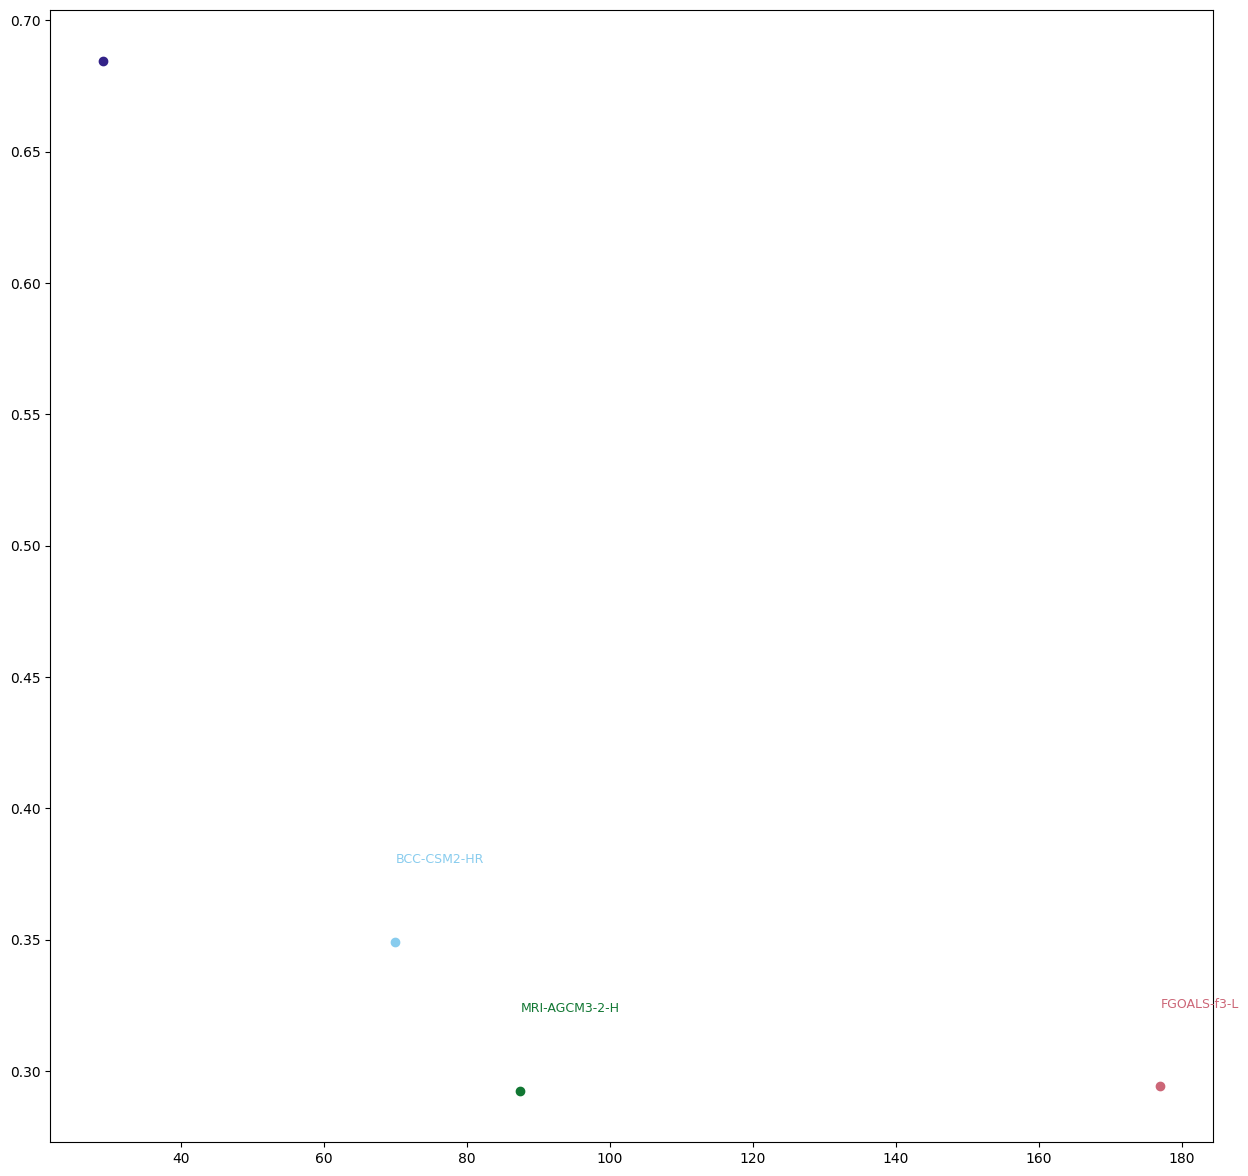

In [71]:
#########ONLY HIGHRESMIP
# bin_count = 20 #np.min(b_coun[0:-1])

for i in range(0,len(hiresmd)):
    bin_count = min(len(W_SFC_O), len(W_SFC_G[i]))
    bias      = W_SFC_O[0:bin_count] - W_SFC_G[i][0:bin_count]
    mean_bias = np.nanmean(bias)

    plt.scatter(g_res[i],mean_bias,label=hiresmd[i],color=use_colors[i])
    plt.annotate(xy=(g_res[i]+0.03,mean_bias+0.03), text=hiresmd[i], color=use_colors[i],fontsize=9)
    # print(modname[i])
    print(g_res[i])